# Muography
#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)
#### Danila Riazanov - Sudent at MIPT, JetBrains Research trainee

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Non-linear Optimisation Algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

## Installation

The `conda` environment provided with the repository has all the required dependencies. For this particular tutorial we will need the following `python` packages:

In [1]:
import torch
from torch.utils.cpp_extension import load

Now we need to build and load `C++17/CUDA` extensions for `PyTorch`, set up the locations:

In [2]:
!mkdir -p build
noa_location = '../..'

If you are running this on Google Colab, you need to clone `NOA` and set `noa_location` accordingly:
```python
!git clone https://github.com/grinisrit/noa.git
noa_location = 'noa'
```

Also, make sure that `ninja` and `g++-9` or higher are available. The following commands will do that for you:
```python
!pip install Ninja
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt update
!apt install gcc-9 g++-9
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 100 --slave /usr/bin/g++ g++ /usr/bin/g++-9
!apt upgrade -y
!gcc --version
!g++ --version
!nvcc --version
```
Finally, you get the extensions into `python` by calling `load`:

In [3]:
!git clone https://github.com/grinisrit/noa.git
noa_location = 'noa'

Cloning into 'noa'...
remote: Enumerating objects: 2374, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 2374 (delta 245), reused 293 (delta 166), pack-reused 1952
Receiving objects: 100% (2374/2374), 20.64 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (1431/1431), done.


In [4]:
!pip install Ninja
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt update
!apt install gcc-9 g++-9
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 100 --slave /usr/bin/g++ g++ /usr/bin/g++-9
!apt upgrade -y
!gcc --version
!g++ --version
!nvcc --version

     |████████████████████████████████| 108 kB 4.0 MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [543 kB]
Get:14 http://a

In [5]:
muons = load(name='muons',
             build_directory='./build',
             sources=[f'{noa_location}/docs/pms/muons.cc'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [ ]:
muons_cuda = load(name='muons_cuda',
             build_directory='./build',       
             sources=[f'{noa_location}/docs/pms/muons.cu'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

## Differential Cross-Section calculations

Differential cross-sections (DCS) are implemented in `<noa/pms/dcs.hh>` for `CPU` and `<noa/pms/dcs.cuh>` for `CUDA` within the namespace `noa::pms::dcs`.

Here, we demonstrate the calculations for muons passing through the standard rock. In `<noa/pms/constants.hh>` you will find:
```cpp
constexpr ParticleMass MUON_MASS = 0.10565839;     // GeV/c^2

constexpr AtomicElement<Scalar> STANDARD_ROCK =
            AtomicElement<Scalar>{
                    22.,       // Atomic mass in g/mol
                    0.1364E-6, // Mean Excitation in GeV
                    11 // Atomic number
    };
```

Let's get a range of kinetic and recoil energies:

In [ ]:
kinetic_energies = torch.linspace(1e-3, 1e6, 10000).double()
recoil_energies = 0.0505 * kinetic_energies

In [ ]:
kinetic_energies_gpu = kinetic_energies.cuda()
recoil_energies_gpu = recoil_energies.cuda()

In [ ]:
kinetic_energies_gpu[:5]

tensor([1.0000e-03, 1.0001e+02, 2.0002e+02, 3.0003e+02, 4.0004e+02],
       device='cuda:0', dtype=torch.float64)

From now on, we shall get ourselves into the namespace:
```cpp
using namespace noa::pms;
```
On `CPU` the DCS computation kernel can be mapped on a tensor via the utility `dcs::vmap`. The user is expected to provide a `result` tensor with the same options as `kinetic_energies` which will get populated with the calculation values:
```cpp
const auto result = torch::zeros_like(kinetic_energies);
```

### Bremsstrahlung

Bremsstrahlung dominates other muon interaction processes in the region of catastrophic collisions (𝑣 ≥ 0.1 ), that is
at “moderate” muon energies above the kinematic limit for knock–on electron production. At high energies (𝐸 ≥ 1
TeV) this process contributes about 40% of the average muon energy loss.

##### Input:
   * K - The projectile initial kinetic energy, in GeV
   * q - The kinetic energy lost to the photon, in GeV
   * A - The mass number of the target atom, in g/mol
   * Z - The charge number of the target atom.
   * mu - The projectile rest mass, in GeV
   

##### Output:
    DCS (differential crros-section) in m^2/kg.
    
#### Definitions and Applicability

Theory from: https://pdg.lbl.gov/2014/AtomicNuclearProperties/adndt.pdf.

The formula for the differential cross section applies when:

* 𝐸 ≫ 𝜇, hence the ultrarelativistic approximation is used
* 𝐸 ≤ $10^{20}$ eV; above this energy, LPM suppression can be expected
* 𝑣 ≥ $10^{−6}$ ; below $10^{−6}$ Ter-Mikaelyan suppression takes place. However, in the latter region the cross section
of muon bremsstrahlung is several orders of magnitude less than that of other processes.
The Coulomb correction (for high 𝑍) is not included. However, existing calculations [AB97] show that for muon
bremsstrahlung this correction is small.

##### Formulae

\begin{equation}
\frac{\text{d}\sigma}{\text{d}\nu} = \left.\frac{\text{d}\sigma}{\text{d}\nu}\right|_\text{brems, elec} + \left.\frac{\text{d}\sigma}{\text{d}\nu}\right|_\text{brems, nucl}
\end{equation}

The differential cross section for muon bremsstrahlung from a (screened) nucleus:

\begin{equation}
\left.\frac{\text{d}\sigma}{\text{d}\nu}\right|_\text{brems, nucl} = \alpha(2Z\frac{m_e}{M_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)\Phi_n(\delta)
\end{equation}

To account for bremsstrahlung losses on atomic electrons, approximation for the contribution from electrons, taking into account electronic binding and recoil, is 

\begin{equation}
\left.\frac{\text{d}\sigma}{\text{d}\nu}\right|_\text{brems, elec} = \alpha Z(2\frac{m_e}{M_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)\Phi_\text{in}(\delta)
\end{equation}

\begin{equation}
\frac{\text{d}\sigma}{\text{d}\nu} = \alpha Z(2\frac{m_e}{M_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) )
\end{equation}
 
Here $\nu = \frac{q}{E}$ is the fraction of the muon's energy transferred to the photon, and 

\begin{equation}
\Phi(\delta) = \ln(\frac{BZ^{\frac{-1}{3}}(M_\mu + \delta(D_n\sqrt{e} - 2))}{(m_e + \delta \sqrt{e}BZ^{\frac{-1}{3}})D_n},
\end{equation}

where $D_n = 1.54A^{0.27}$ , $B = 182.7$ ($B = 202.4$ for hygrogen), $e = 2.7181...$ and

\begin{equation}
\delta = \frac{M_\mu^{2}\nu}{2E(1 - \nu)}
\end{equation}

\begin{equation}
\Phi_\text{in}(\delta) = \ln(\frac{M_\mu BZ^{-2/3} \sqrt{e}}{(m_e + \delta  BZ^{-2/3} \sqrt{e})(\frac{M_\mu \delta}{m_e^{2}} + \sqrt{e})}),
\end{equation}

where $B = 1429$ for all elements but hydrogen, where $B = 446$

For our calculations we use differential cross section, as 
\begin{equation}
\frac{\text{d} \sigma}{\text{d} q} = \frac{\text{d}\sigma}{\text{d}\nu E}
\end{equation}
This formula takes the form:
\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \frac{\alpha Z}{E}(2\frac{m_e}{M_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) )
\end{equation}
But, this DCS in $\frac{m^2}{Gev}$. We need to multiply by Avogadro's number, energy and divide by the mass number of the target atom to get DCS in $\frac{m^2}{kg}$.

The final formula:
\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \frac{\alpha Z}{E}(2\frac{m_e}{M_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) ) \frac{N_a E}{A}
\end{equation}

And take into account, that A in g/mol

\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \frac{\alpha Z}{E}(2\frac{m_e}{M_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) ) \frac{1000 N_a E}{A}
\end{equation}

For `CPU` we have:
```cpp
dcs::vmap(dcs::pumas::bremsstrahlung)(
    result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```
For `CUDA` we create the lambda function directly ourselves:
```cpp
dcs::pumas::cuda::vmap_bremsstrahlung(
    result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [ ]:
brems = muons.bremsstrahlung(kinetic_energies, recoil_energies)
brems[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)

In [ ]:
brems_gpu = muons_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);
brems_gpu[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       device='cuda:0', dtype=torch.float64)

In [ ]:
(brems - brems_gpu.cpu()).abs().sum()

tensor(3.2179e-18, dtype=torch.float64)

In [ ]:
%timeit muons_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);

157 µs ± 3.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit muons.bremsstrahlung(kinetic_energies, recoil_energies);

326 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Pair Production

Direct electron pair production is one of the most important muon interaction processes. At TeV muon energies,
the pair production cross section exceeds those of other muon interaction processes over a range of energy transfers
between 100 MeV and 0.1𝐸𝜇. The average energy loss for pair production increases linearly with muon energy, and
in the TeV region this process contributes more than half the total energy loss rate.

To adequately describe the number of pairs produced, the average energy loss and the stochastic energy loss distribution,
the differential cross section behavior over an energy transfer range of 5 MeV ≤ 𝜖 ≤ 0.1 ·𝐸𝜇 must be accurately
reproduced. This is is because the main contribution to the total cross section is given by transferred energies 5 MeV
≤ 𝜖 ≤ 0.01 ·𝐸𝜇, and because the contribution to the average muon energy loss is determined mostly in the region
0.001 · 𝐸𝜇 ≤ 𝜖 ≤ 0.1 ·𝐸𝜇 .

##### Input:
   * Z - The charge number of the target atom.
   * A - The mass number of the target atom.
   * mass - The projectile rest mass, in GeV
   * K - The projectile initial kinetic energy.
   * q - The kinetic energy lost to the photon ($E - E^{\text{'}}$).
   
##### Output:
    DCS in m^2/kg.
    
#### Definitions and Applicability

Theory from https://geant4-userdoc.web.cern.ch/UsersGuides/PhysicsReferenceManual/fo/PhysicsReferenceManual.pdf (Page 151)

Coefficients for the Gaussian quadrature from:
https://pomax.github.io/bezierinfo/legendre-gauss.html.

The formula for the differential cross section applies when:
* $E_\mu \gg \mu $ $ ( E \geq 2 - 5 GeV)$ and $E_\mu \leq 10^{15} - 10^{17} eV $. If muon energies exceed this limit, the LPM (Landau Pomeranchuk Migdal) effect may become important, depending on the material.
*The muon energy transfer $q$ lies between $q_\text{min} = 4m_e$ and $q_\text{max} = E_\mu - \frac{3\sqrt{e}}{4} M_\mu Z^{1/3}$, although the formal lower limit is $q \gg 2m_e$, and the formal upper limit requires $E_\mu ^\text{'} \gg \mu$.
*$Z \leq 40 - 50$. For higher Z, the Coulomb correction is important but has not been sufficiently studied theoretically.

##### Formulae

\begin{equation}
\frac{\text{d}\sigma}{\text{d}q}(Z, A, E, q) = \frac{4}{3\pi} \frac{Z(Z + \xi(Z))}{A} N_A {(\alpha r_e)}^{2} (\frac{1 - \nu}{q}) \int_{p}[\Phi_e + (m_e/M_\mu)^{2}\Phi_\mu]dp,
\end{equation}

where $\Phi_{e,\mu} = B_{e,\mu} {L_{e,\mu}}^{'}$  and  $\Phi_{e,\mu} = 0 \text{  whenever  } \Phi_{e,\mu}<0$.

$B_e$ and $B_\mu$ do not depend on Z, A, and are given by

\begin{equation}
B_e = [(2 + \rho^{2})(1 + \beta) + \xi(3 + \rho^{2})]\ln(1 + \frac{1}{\xi}) + \frac{1 - \rho^{2} - \beta}{1 + \xi} - (3 + \rho^{2})
\approx \frac{1}{2\xi}[(3 - \rho^{2}) + 2\beta(z + \rho^{2})] \text{ for } \xi \geq 10 ^{3}
\end{equation}

\begin{equation}
B_\mu = [(1 + \rho^{2})(1 + \frac{3\beta}{2}) - \frac{1}{\xi}(1 + 2\beta)(1 - \rho^{2})]\ln(1 + \xi) + \frac{\xi(1 - \rho{2} - \beta)}{1 + \xi} + (1 + 2\beta)(1 - \rho^{2})
\approx \frac{\xi}{2}[(5 - \rho^{2}) + \beta(3 + \rho^{2})] \text{ for } \xi \leq 10^{-3}
\end{equation}

Also,


\begin{equation}
\xi = \frac{\mu^{2}\nu^{2}}{4m^{2}} \frac{(1 - \rho^{2})}{1 - \nu}; \text{ }
\beta = \frac{\nu^{2}}{2(1 - \nu)}
\end{equation}

\begin{equation}
L_e^\text{'} = \ln(\frac{A^{*}Z^{-1/3} \sqrt{(1 + \xi)(1 + Y_e)}}{1 + \frac{2m\sqrt{e}A*Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - \rho^{2})}})  - \frac{1}{2}ln([1 + (\frac{3mZ^{1/3}}{2\mu})^{2}(1 + \xi)(1 + Y_e)])
\end{equation}

\begin{equation}
L_\mu ^\text{'} = \ln(\frac{(\frac{M_\mu}{m_e})A^{*}Z^{-1/3} \sqrt{(1 + \frac{1}{\xi})(1 + Y_e)}}{1 + \frac{2m\sqrt{e}A*Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - \rho^{2})}})  - ln(\frac{3}{2} Z^{1/3}\sqrt{(1 + \frac{1}{\xi})(1 + Y_\mu)})
\end{equation}

For faster computing, the expressions for $L_{e, \mu} ^\text{'}$ are further algebraically transformed. The function $L_{e, \mu} ^\text{'}$ include the nuclear size correction in comparison with parameterization.

\begin{equation}
Y_e = \frac{5 - \rho^2 + 4\beta(1 + \rho^2)}{2(1 + 3\beta)\ln(3 + 1/\xi)) - \rho^2 - 2\beta(2 - \rho^2)}
\end{equation}

\begin{equation}
Y_\mu = \frac{4 + \rho^2 + 3\beta(1 + \rho^2)}{(1 + \rho^2)(\frac{3}{2} + 2\beta)\ln(3 + \xi) + 1 - \frac{3}{2}\rho^2}
\end{equation}

\begin{equation}
\rho_{max} = 1 - \frac{6M_\mu^2}{E^2(1 - \nu)})\sqrt{1 - \frac{4m_e}{E\nu}} 
\end{equation}

```cpp
dcs::vmap(dcs::pumas::pair_production)(
            result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [ ]:
ppair = muons.pair_production(kinetic_energies, recoil_energies)
ppair[:5]

tensor([0.0000e+00, 6.5366e-06, 7.3699e-06, 7.7919e-06, 8.0572e-06],
       dtype=torch.float64)

### Photonuclear

Input:
   * Z - The charge number of the target atom.
   * A - The mass number of the target atom.
   * ml - The projectile rest mass, in GeV
   * K - The projectile initial kinetic energy.
   * q - The kinetic energy lost to the photon. 

Output:
    DCS in m^2/kg.
    
#### Definitions and Applicability

Theory from: https://arxiv.org/pdf/hep-ph/9712415.pdf, https://arxiv.org/pdf/hep-ph/0012350.pdf
  
The inelastic interaction of muons with nuclei is important at high muon energies (𝐸 ≥ 10 GeV), and at relatively high
energy transfers 𝜈 (𝜈/𝐸 ≥ 10−2). It is especially important for light materials and for the study of detector response
to high energy muons, muon propagation and muon-induced hadronic background. The average energy loss for this
process increases almost linearly with energy, and at TeV muon energies constitutes about 10% of the energy loss rate.

The main contribution to the cross section 𝜎(𝐸, 𝜈) and energy loss comes from the low 𝑄2–region ( 𝑄2 ≪ 1 GeV2).
In this domain, many simplifications can be made in the theoretical consideration of the process in order to obtain
convenient and simple formulae for the cross section. Most widely used are the expressions given by Borog and
Petrukhin [BP75], and Bezrukov and Bugaev [BB81]. Results from these authors agree within 10% for the differential
cross section and within about 5% for the average energy loss, provided the same photonuclear cross section, 𝜎𝛾𝑁, is
used in the calculations.

##### Formulae

The differential cross section can be written in the form

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{4\pi\alpha^2}{Q^4}\frac{F_2(x, Q^2)}{x}(1-y-\frac{Mxy}{2E} + (1 - \frac{2m_l^2}{Q^2})\frac{y^2(1 + \frac{4M^2x^2}{Q^2})}{2(1 + R(x, Q^2))})
\end{equation}

Where $F_2$ - a nucleon structure function

\begin{equation}
F_2(x, Q^2) = \frac{Q^2}{Q^2 + m_0^2} (F_2^P(x, Q^2) + F_2^R(x, Q^2))
\end{equation}

\begin{equation}
F_2 ^{R}(x, Q^{2}) = c_R(t)x_R^{a_R(t)}(1 - x)^{b_R(t)} 
= c_R(t)e^{a_R(t)\ln x_R+ b_R(t)\ln(1 - x)}
\end{equation}

\begin{equation}
F_2 ^{P}(x, Q^{2}) = c_P(t)x_P^{a_P(t)}(1 - x)^{b_P(t)} 
= c_P(t)e^{\ln(x_P^{a_P(t)}(1 - x)^{b_P(t)})}
= c_P(t)e^{\ln x_P^{a_P(t)}+ \ln(1 - x)^{b_P(t)}}
= c_P(t)e^{a_P(t)\ln x_P+ b_P(t)\ln(1 - x)}
\end{equation}

Take $x$ as $x = \frac{Q^2}{2Mq}$

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{4\pi\alpha^2 F_2}{Q^4} \frac{2Mq}{Q^2}(1 - y - \frac{My}{2E}\frac{Q^2}{2Mq} + (1 - \frac{2m_l^2}{Q^2})\frac{y^2(1 + (\frac{2MQ^2}{2MqQ})^2)}{2(1 + R)})
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y - \frac{Q^2y}{4Eq} + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + (y\frac{Q}{q})^2}{2(1 + R)})
\end{equation}

Take into account, that $y = \frac{q}{E}$ 

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y - \frac{Q^2}{4E^2} + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)})
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y  + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) - \frac{8\pi\alpha^2F_2Mq}{Q^6}\frac{Q^2}{4E^2}
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y  + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) - \frac{8\pi\alpha^2F_2Mq}{4Q^4E^2}
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^2}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{equation}

Let's see on $x = \frac{Q^2}{2Mq}$

\begin{equation}
\frac{\text{d}x}{\text{d}q} = \frac{-Q^2}{2Mq^2}
\end{equation}

And
\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q}\frac{2Mq^2}{-Q^2} = \frac{8\pi\alpha^2F_2Mq}{Q^2}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q} = \frac{-4\pi\alpha^2F_2}{q}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{equation}

So it's not enough correct equation. We should add some approximation factors. And finally we have:

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q} = \frac{\text{cf} F_2}{q} (\frac{1-y+\frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac {y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4} - \frac{1}{4E^2Q^2})
\end{equation}

Then integrate this equation using Gaussian Quadrature from $Q_\text{min}^2 = \frac{m_l^2y^2}{1 - y} $ to $Q_\text{max}^2 = 2MEy - ((M + m_\pi)^2 - M^2) $


\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \int{\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q}}\text{d}Q^2
\end{equation}

```cpp
dcs::vmap(dcs::pumas::photonuclear)(
            result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [ ]:
photonuc = muons.photonuclear(kinetic_energies, recoil_energies)
photonuc[:5]

tensor([0.0000e+00, 2.2912e-06, 2.1304e-06, 2.0719e-06, 2.0427e-06],
       dtype=torch.float64)

### Ionisation

Input:
   * A - The charge number of the target atom.
   * I - The mean excitation of the target atom. 
   * Z - The mass number of the target atom.
   * mu - The projectile rest mass, in GeV
   * K - The projectile initial kinetic energy.
   * q - The kinetic energy lost to the photon.
  
Output:
    DCS in m^2/kg.
    
### Definitions and Applicability

Theory from: Salvat et al., NIMB316 (2013) 144-159, Sokalski et al., Phys.Rev.D64 (2001) 074015 (MUM)

The differential cross section for ionisation is computed following Salvat et al., NIMB316 (2013) 144-159, considering only close interactions for DELs. In addition a radiative correction is applied according toSokalski et al., Phys.Rev.D64 (2001) 074015 (MUM).

\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \frac{CEZ}{A(\frac{1}{2P_2} + \frac{P_2W_\text{max}}{E^2W_\text{max} - qP_2})}(1 + \Delta_{e\gamma}),
\end{equation}

where $P_2 = E^2 - M_\mu^2$, $W_{max} = \frac{2m_e P_2}{M_\mu^2 + m_e(m_e + 2E)}$ and $C = 1.535336*10^{-5}$ 

$\Delta_{e\gamma}$ - Radiative correction

\begin{equation}
\Delta_{e\gamma} = \frac{\alpha}{2\pi}\ln(1 + \frac{2\nu E}{m_e})(\ln(\frac{4E^2(1 - \nu)}{M_\mu^2}) - \ln(1 + \frac{2\nu E}{m_e}))
\end{equation}

If we take into account, that $\nu = \frac{q}{E}$

\begin{equation}
\Delta_{e\gamma} = \frac{\alpha}{2\pi}\ln(1 + \frac{2q}{m_e})(\ln(\frac{4E(E - q)}{M_\mu^2}) - \ln(1 + \frac{2q}{m_e}))
\end{equation}

```cpp
dcs::vmap(dcs::pumas::ionisation)(
            result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [ ]:
ionis = muons.ionisation(kinetic_energies, recoil_energies)
ionis[:5]

tensor([0.0000e+00, 3.0168e-05, 1.5300e-05, 1.0284e-05, 7.7575e-06],
       dtype=torch.float64)

Energy level:  1e-05
Energy level:  1111.11112
Energy level:  2222.2222300000003
Energy level:  3333.3333400000006
Energy level:  4444.44445
Energy level:  5555.55556
Energy level:  6666.6666700000005
Energy level:  7777.77778
Energy level:  8888.88889
Energy level:  10000.0


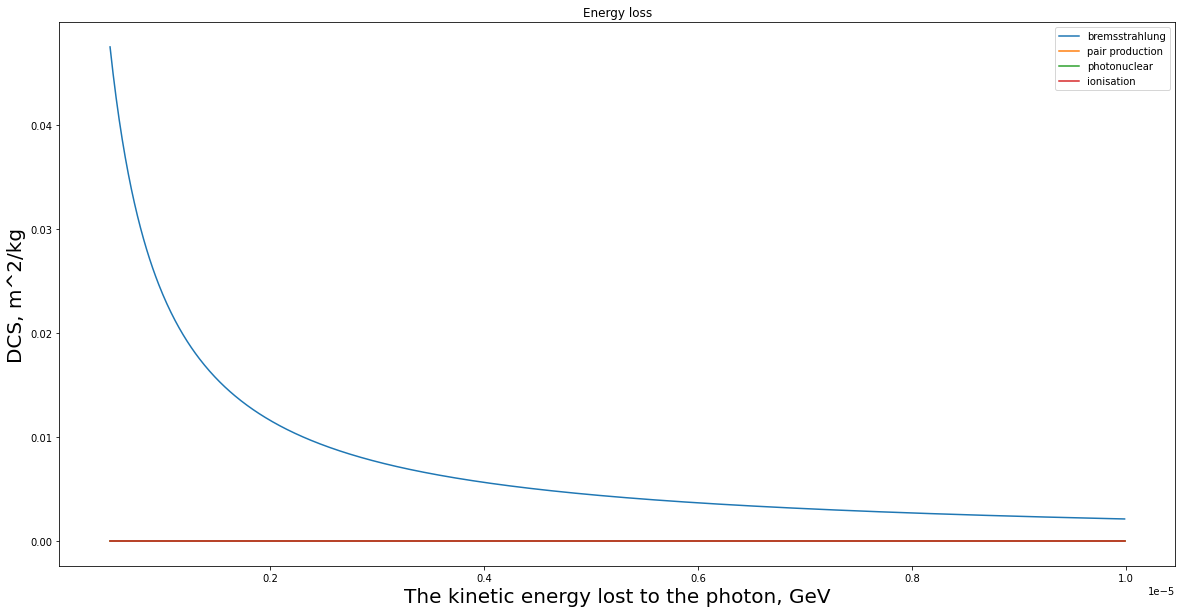

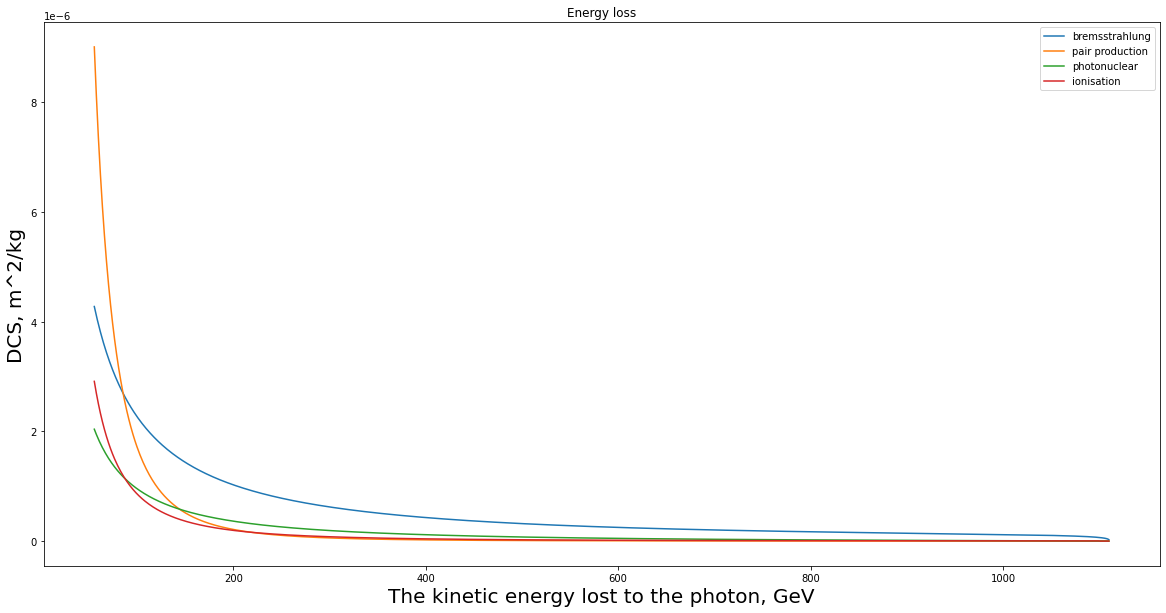

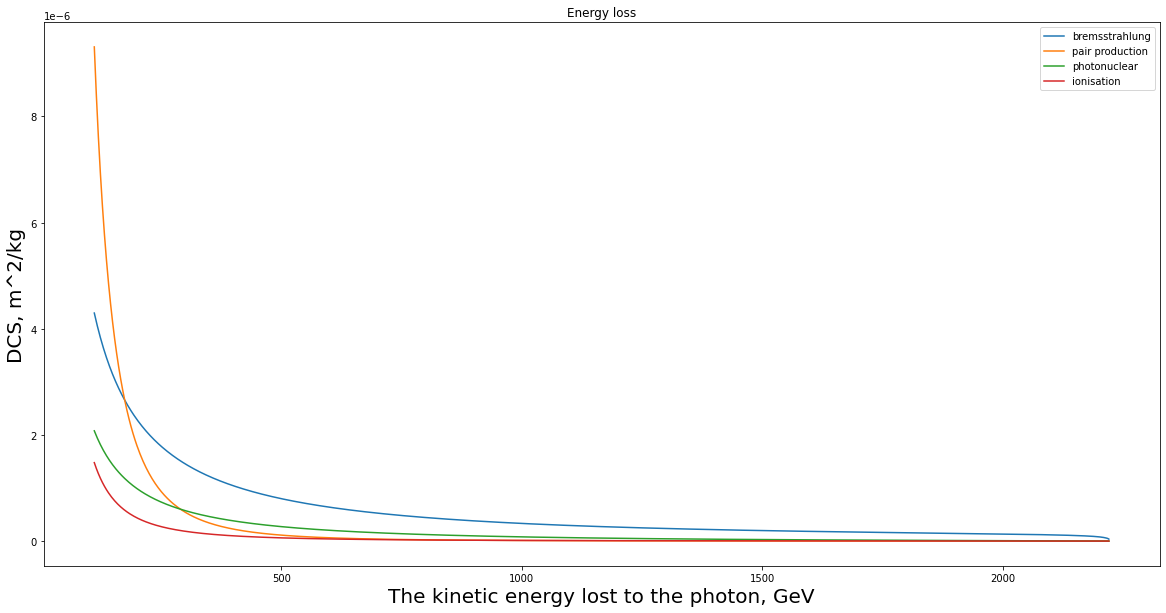

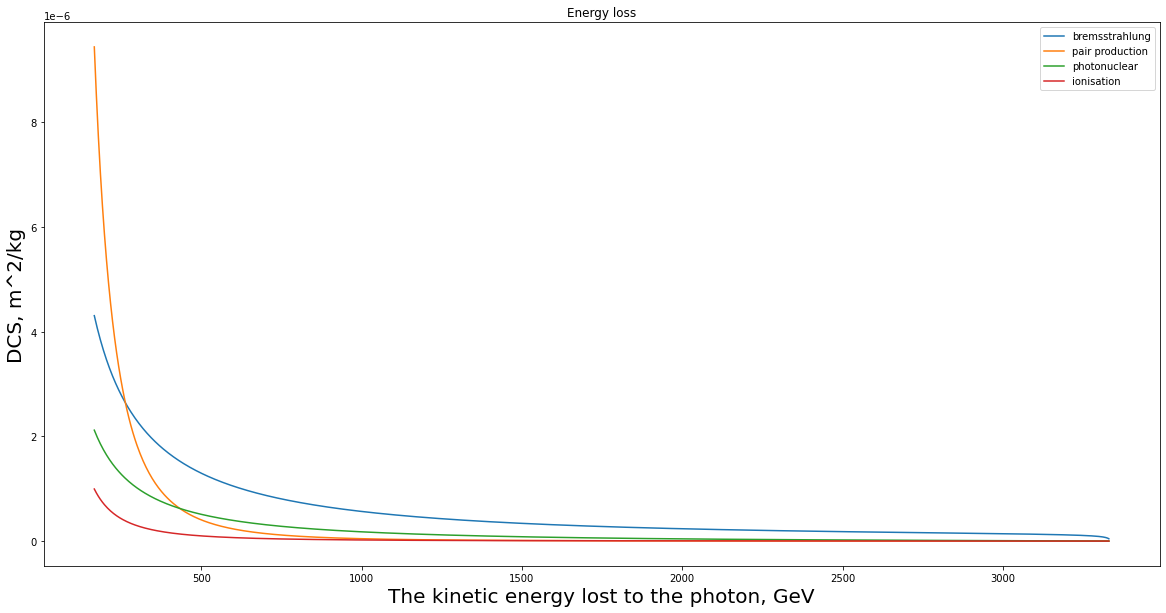

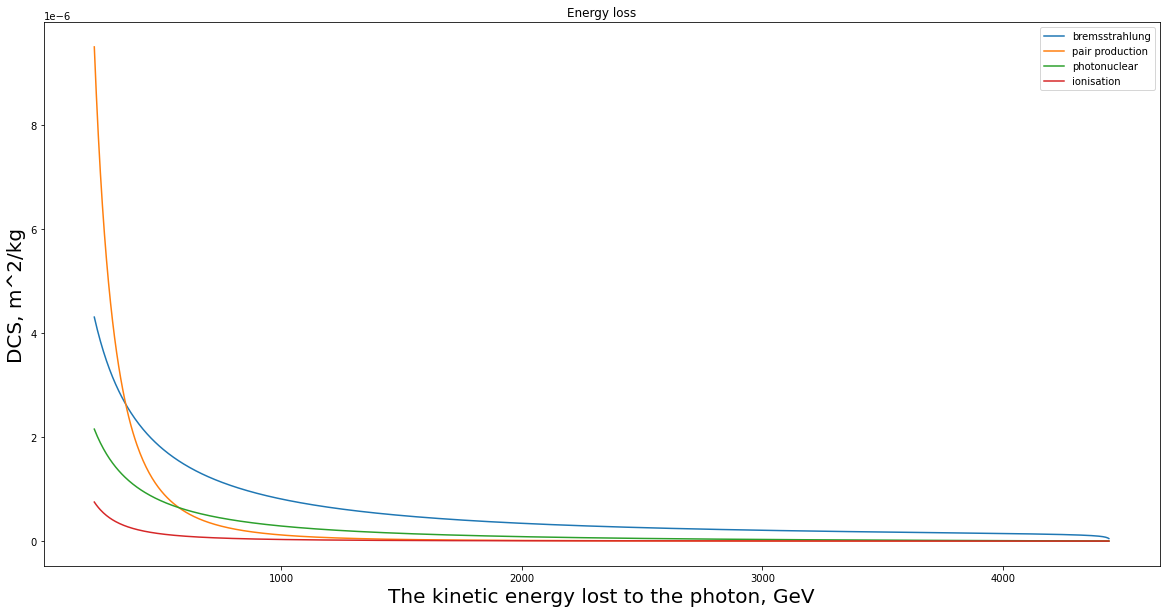

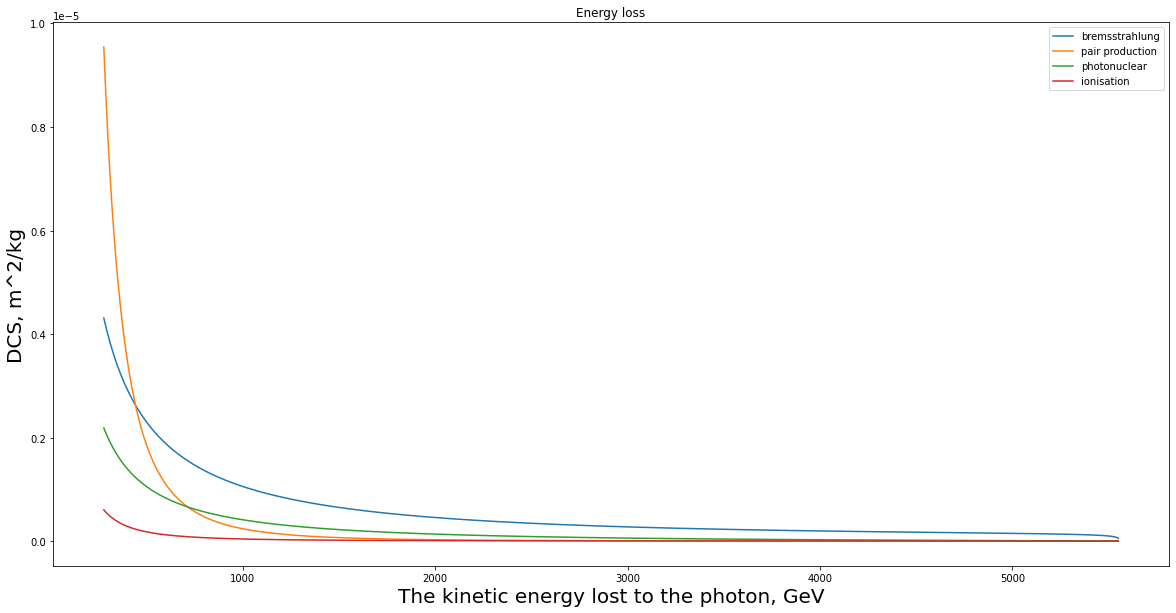

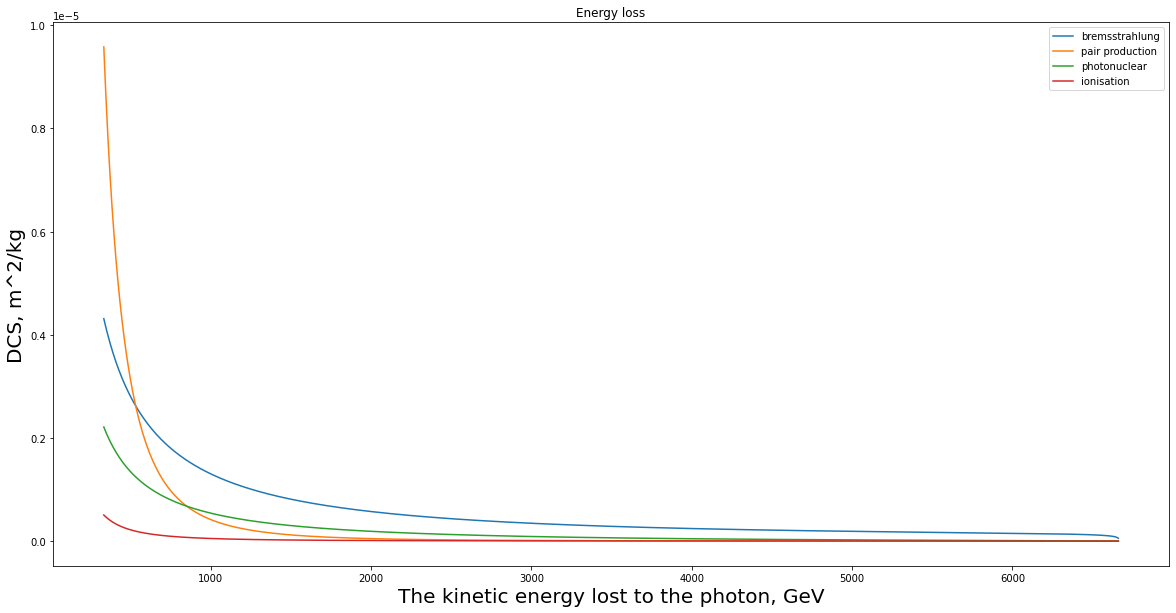

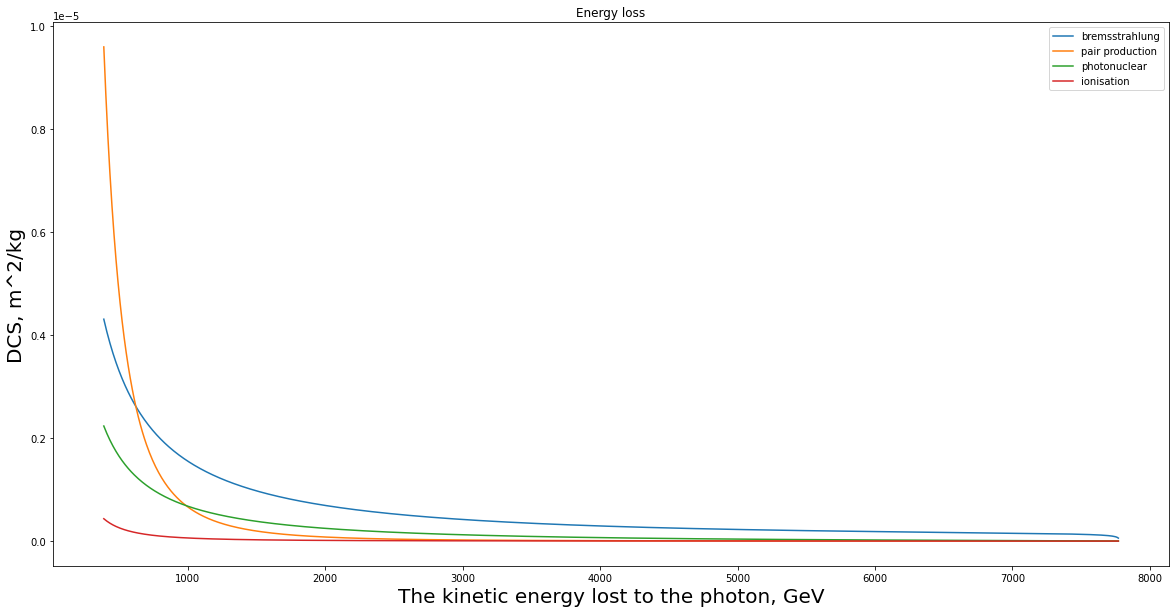

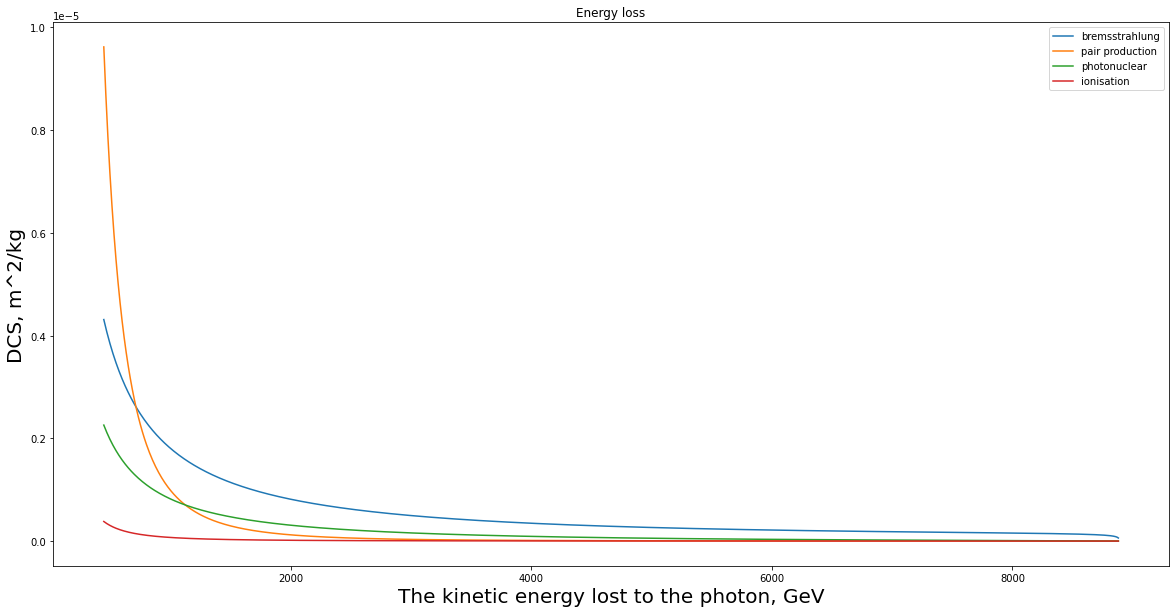

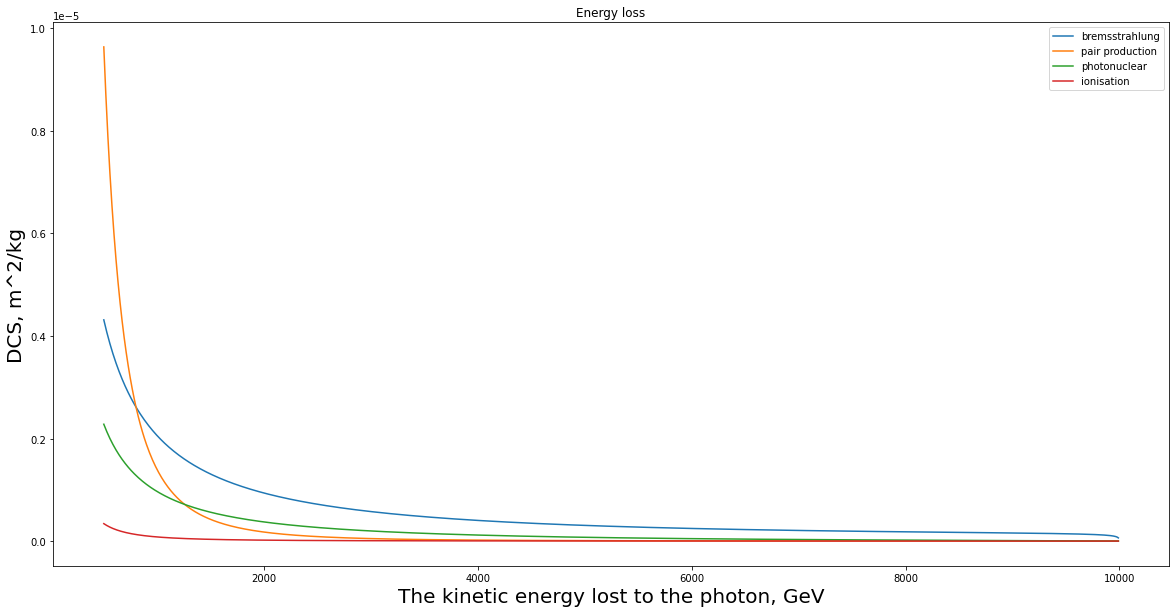

In [26]:
import numpy as np
import matplotlib.pyplot as plt

sample = 1000 #amount of points

recoil_energies = np.zeros(sample)

E = np.linspace(0.00001, 10000, 10 ) #array with different energy levels

for j in range(10):

  kinetic_energies_np = np.full(sample, E[j]) #numpy array with one energy level
  kinetic_energies_torch = torch.Tensor(kinetic_energies_np).double() 

  for i in range(sample):
    recoil_energies[i] = E[j]*(0.05 + i*(1 - 0.05)/sample)

  recoil_energies_torch = torch.Tensor(recoil_energies).double()  

  brems = muons.bremsstrahlung(kinetic_energies_torch, recoil_energies_torch)
  ppair = muons.pair_production(kinetic_energies_torch, recoil_energies_torch)
  photonuc = muons.photonuclear(kinetic_energies_torch, recoil_energies_torch)
  ionis = muons.ionisation(kinetic_energies_torch, recoil_energies_torch)

  print("Energy level: ", E[j])

  fig, ax = plt.subplots()
  ax.plot(recoil_energies, brems.numpy(), label = 'bremsstrahlung')
  ax.plot(recoil_energies, ppair.numpy(), label = 'pair production')
  ax.plot(recoil_energies, photonuc, label = 'photonuclear')  
  ax.plot(recoil_energies, ionis.numpy(), label = 'ionisation') 

  ax.set_xlabel('The kinetic energy lost to the photon, GeV', fontsize = 20)
  ax.set_ylabel('DCS, m^2/kg', fontsize = 20)
  ax.set_title("Energy loss")

  fig.set_figwidth(20)
  fig.set_figheight(10)

  ax.legend()
